# Mean field Floquet dynamics



We introduce the position-momentum conjugate and effective Planck constant $1/N$ the Schroedinger equation becomes-
$$\frac{i}{N} \frac{\partial}{\partial t}\psi_t(q) = \mathcal{H}\psi_t(q)$$
Where hamiltonian 
$$H = -2q^2 -h(t)\sqrt{(1-4q^2)}cos(p)$$
Now we want to find one cycle evolution for Floquet matrix.
The initial condition for wave function is a unitary matrix of which each column is the nth state's initial condition. This means we have to descretize the position as well as momentum space with descrete Hamiltonian.
<br> The position space spans as-
$$
q = (q_0, q_1,q_2,....,q_{N-1})
$$
And momentum is related with position as-
$$
p = \frac{i}{N}\frac{\partial}{\partial q}
$$
So we can write-
$$ \mathcal{H} {|\psi\rangle} = \frac{i}{N}\frac{\partial{|\psi\rangle}}{\partial t}$$
Here the wavefunction-
$$
|\psi \rangle = \left(\begin{array}(
|\psi_0 \rangle\\
|\psi_1 \rangle\\
|\psi_2 \rangle\\
..\\
..\\
|\psi_{N-1} \rangle
\end{array}\right)
$$

Now we can write momentum in descerte space with finite difference method as- 
$$
p^n |\psi\rangle = \frac{i^n}{N^n}\frac{\partial ^n}{\partial q ^n}|\psi\rangle \Longrightarrow^{discrete} \sum_{j=0}^{n} (-1)^j C^{n}_{j} |\psi\rangle_{k+(\frac{n}{2}-j)} = \left(p^n |\psi\rangle \right)_k
$$

<br> McLaurent series for cos(p)-
$$
\left(cos(p) |\psi\rangle \right)_k = \sum_{l=0}^{N} \frac{(-1)^l p^{2l}}{2l!} = \sum_{l=0}^{N} \sum_{j=0}^{l} \frac{(-1)^{(l+j)}}{2l!} C^{l}_{j} |\psi\rangle_{k +(l-j)}
$$

<br> Here j,k,l are integers only.
Now,
$$
\left(\mathcal{H}|\psi\rangle \right)_k = \widetilde{H}_{km} \psi_m
$$
here $C^{n}_{j}$ is for binomial combination.

References:
[1] Check T. Mori's paper equation (12)

running for N =  20 with 2 processors
time taken 80.87874174118042 sec


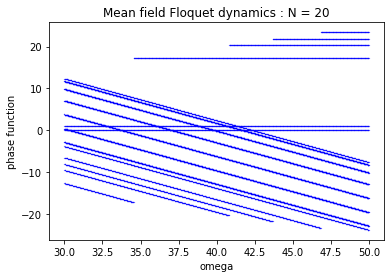

In [4]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 20
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(30.0,50.0,1000)
bessel = 41.583499667
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w                       # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        omega = [omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.2)
    plt.title("Mean field Floquet dynamics : N = 20")    
    plt.xlabel("omega")
    plt.ylabel("phase function")
    plt.show()

running for N =  40 with 2 processors
time taken 67.7730484008789 sec


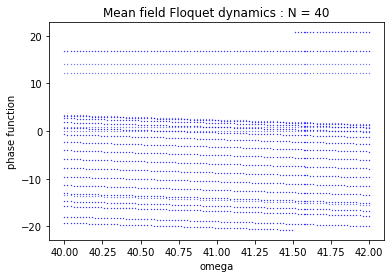

In [7]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(40.0,42.0,100)
bessel = 41.583499667
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w                       # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        omega = [omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.2)
    plt.title("Mean field Floquet dynamics : N = 40")    
    plt.xlabel("omega")
    plt.ylabel("phase function")
    plt.show()